This notebook is a mimic of an awesome blog post http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

to explain how does Metropolis-Hasting algorithm and Markov Chain Monte Carlo (MCMC) work under the hood.

In [27]:
import numpy as np
import pymc3 as pm
import scipy.stats

import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [45]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)
        

We randomly draw data points from a standard normal distribution $\mathcal{N}(0, 1)$. 

From the data points we would like to infer the the mean of the distribution (assuming that we know the variance, $\sigma^2 = 1$)

In [67]:
data = np.random.randn(30)

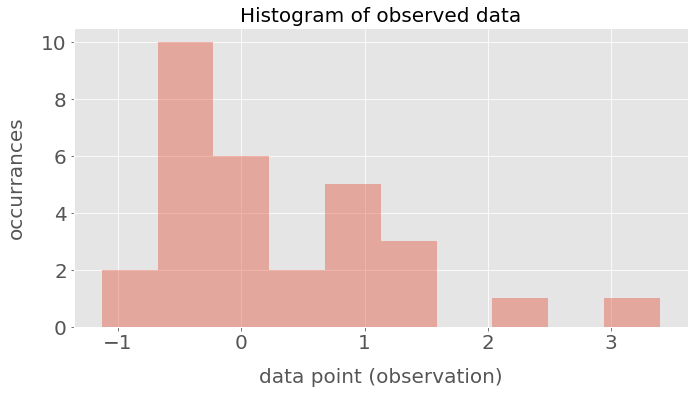

In [77]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(11, 5.5))
sbn.distplot(data, kde=False, ax=ax, bins=10)

ax.set_xlabel('data point (observation)', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('occurrances', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Histogram of observed data', fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)


cf. MLaPP, Chapter 4.4.2

$
\begin{align}
\sigma_N^2 &= (\dfrac{1}{\sigma_0^2} + \dfrac{N}{\sigma_y^2})^{-1}  \newline
\\
\mu_N &= \sigma_N^2 (\dfrac{\mu_0}{\sigma_0^2} + \dfrac{\sum_i y^{(i)}}{\sigma_y^2})
\end{align}
$

Based on the above formula, we can calculate the posterior distribution of $\mu$ and $\sigma^2$ analytically

In [73]:
def calculatePosteriorAnalytical(data, mu_0, sigma_0):
    sigma_data = 1.0
    N = len(data)
    Sigma_post2 = (1.0/sigma_0**2 + float(N)/sigma_data**2)**(-1)
    sigma_post = np.sqrt(Sigma_post2)
    mu_post = Sigma_post2 * (mu_0 / sigma_0**2 + data.sum() / sigma_data**2)
    return scipy.stats.norm(mu_post, sigma_post)


In [74]:
x_vals = np.linspace(-1, 1, 500)
posterior = calculatePosteriorAnalytical(data, 0, 1)
analytical_posterior_vals = posterior.pdf(x_vals)

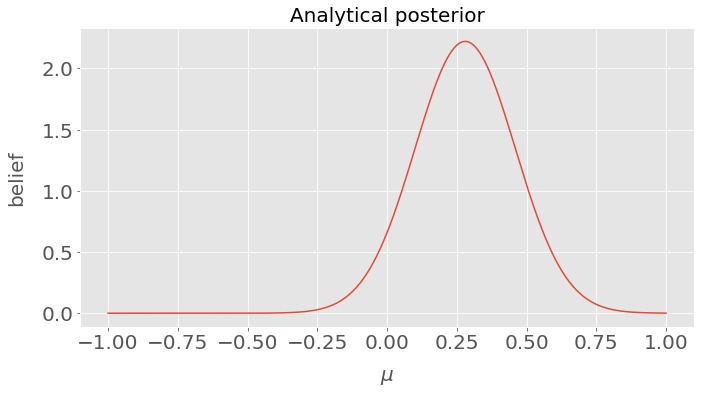

In [76]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(11, 5.5))
ax.plot(xvals, analytical_posterior_vals)

ax.set_xlabel(r'$\mu$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('belief', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Analytical posterior', fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)


In the following, we use MCMC to figure out the posterior distribution of $\mu$

In [78]:
def MCMCsampler(data, n_iterations=100, mu_init=0.5, proposal_width=0.5, mu_0=0, sigma_0=1):
    mu_current = mu_init
    posterior_vals = [mu_current]
    for i in range(n_iterations):
        mu_proposal = scipy.stats.norm(mu_current, proposal_width).rvs()
        
        likelihood_current = scipy.stats.norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = scipy.stats.norm(mu_proposal, 1).pdf(data).prod()
        
        prior_current = scipy.stats.norm(mu_0, sigma_0).pdf(mu_current)
        prior_proposal = scipy.stats.norm(mu_0, sigma_0).pdf(mu_proposal)
        
        posterior_current = likelihood_current * prior_current
        posterior_proposal = likelihood_proposal * prior_proposal        
        
        P_accept = posterior_proposal / posterior_current
        if P_accept > np.random.rand():
            mu_current = mu_proposal
            
        posterior_vals.append(mu_current)
    return posterior_vals


In [79]:
posterior_vals = MCMCsampler(data, n_iterations=15000)

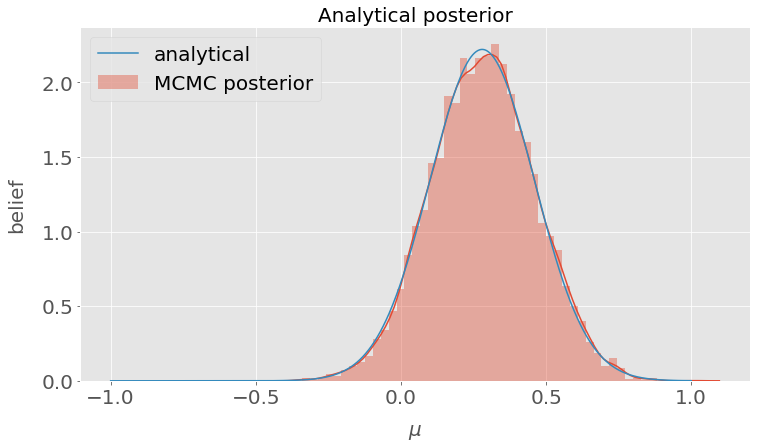

In [83]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(12, 6.5))

# MCMC posterior
sbn.distplot(posterior_vals[2000:], ax=ax, label='MCMC posterior')

# Analytical posterior
x_vals = np.linspace(-1, 1, 1000)
posterior = calculatePosteriorAnalytical(data, 0, 1) 
analytical_posterior_vals = posterior.pdf(x_vals)
ax.plot(x_vals, analytical_posterior_vals, label='analytical')

ax.set_xlabel(r'$\mu$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('belief', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Analytical posterior', fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
_ = ax.legend(fontsize=FONTSIZE)


Below we experiment different proposal_width corresponding to how large is a step change when we propose a new move

In [84]:
posterior_large_width = MCMCsampler(data, n_iterations=5000, mu_init=0.5, proposal_width=3, mu_0=0, sigma_0=1)
posterior_medium_width = MCMCsampler(data, n_iterations=5000, mu_init=0.5, proposal_width=0.5, mu_0=0, sigma_0=1)
posterior_small_width = MCMCsampler(data, n_iterations=5000, mu_init=0.5, proposal_width=0.01, mu_0=0, sigma_0=1)


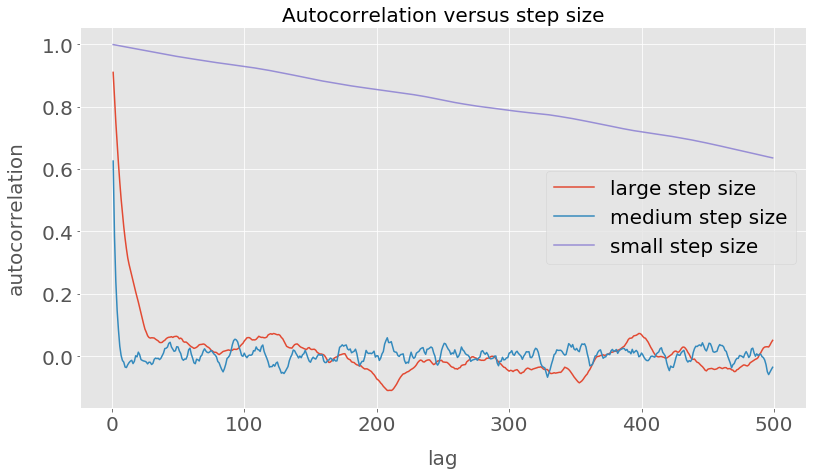

In [86]:
FONTSIZE = 20
fig, ax = plt.subplots(1, figsize=(13, 7))

lags = np.arange(1, 500)
ax.plot(lags, [pm.autocorr(posterior_large_width, l) for l in lags], label='large step size')
ax.plot(lags, [pm.autocorr(posterior_medium_width, l) for l in lags], label='medium step size')
ax.plot(lags, [pm.autocorr(posterior_small_width, l) for l in lags], label='small step size')

ax.set_xlabel('lag', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('autocorrelation', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Autocorrelation versus step size', fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
_ = ax.legend(fontsize=FONTSIZE)
